In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import os

plt.style.use(['science', 'ieee', 'no-latex'])
plt.rcParams['font.size'] = 7
plt.rcParams['axes.labelsize'] = 7

def format(mirror: str) -> int:

    m, n = mirror[:2],  int(mirror[2:])

    if m == 'll': n+= 0
    if m == 'lm': n+= 7
    if m == 'la': n+= 14
    if m == 'co': n+= 21
    if m == 'he': n+= 28

    return n

/tmp/ipykernel_81310/4280398866.py:68: RuntimeWarning: divide by zero encountered in divide
  data.append(cal_xy / cal_std)
/tmp/ipykernel_81310/4280398866.py:69: RuntimeWarning: divide by zero encountered in divide
  data_corr.append(cal_xy_corr / cal_std)
/tmp/ipykernel_81310/4280398866.py:68: RuntimeWarning: divide by zero encountered in divide
  data.append(cal_xy / cal_std)
/tmp/ipykernel_81310/4280398866.py:69: RuntimeWarning: divide by zero encountered in divide
  data_corr.append(cal_xy_corr / cal_std)
/tmp/ipykernel_81310/4280398866.py:68: RuntimeWarning: divide by zero encountered in divide
  data.append(cal_xy / cal_std)
/tmp/ipykernel_81310/4280398866.py:69: RuntimeWarning: divide by zero encountered in divide
  data_corr.append(cal_xy_corr / cal_std)
/tmp/ipykernel_81310/4280398866.py:68: RuntimeWarning: divide by zero encountered in divide
  data.append(cal_xy / cal_std)
/tmp/ipykernel_81310/4280398866.py:69: RuntimeWarning: divide by zero encountered in divide
  data_cor

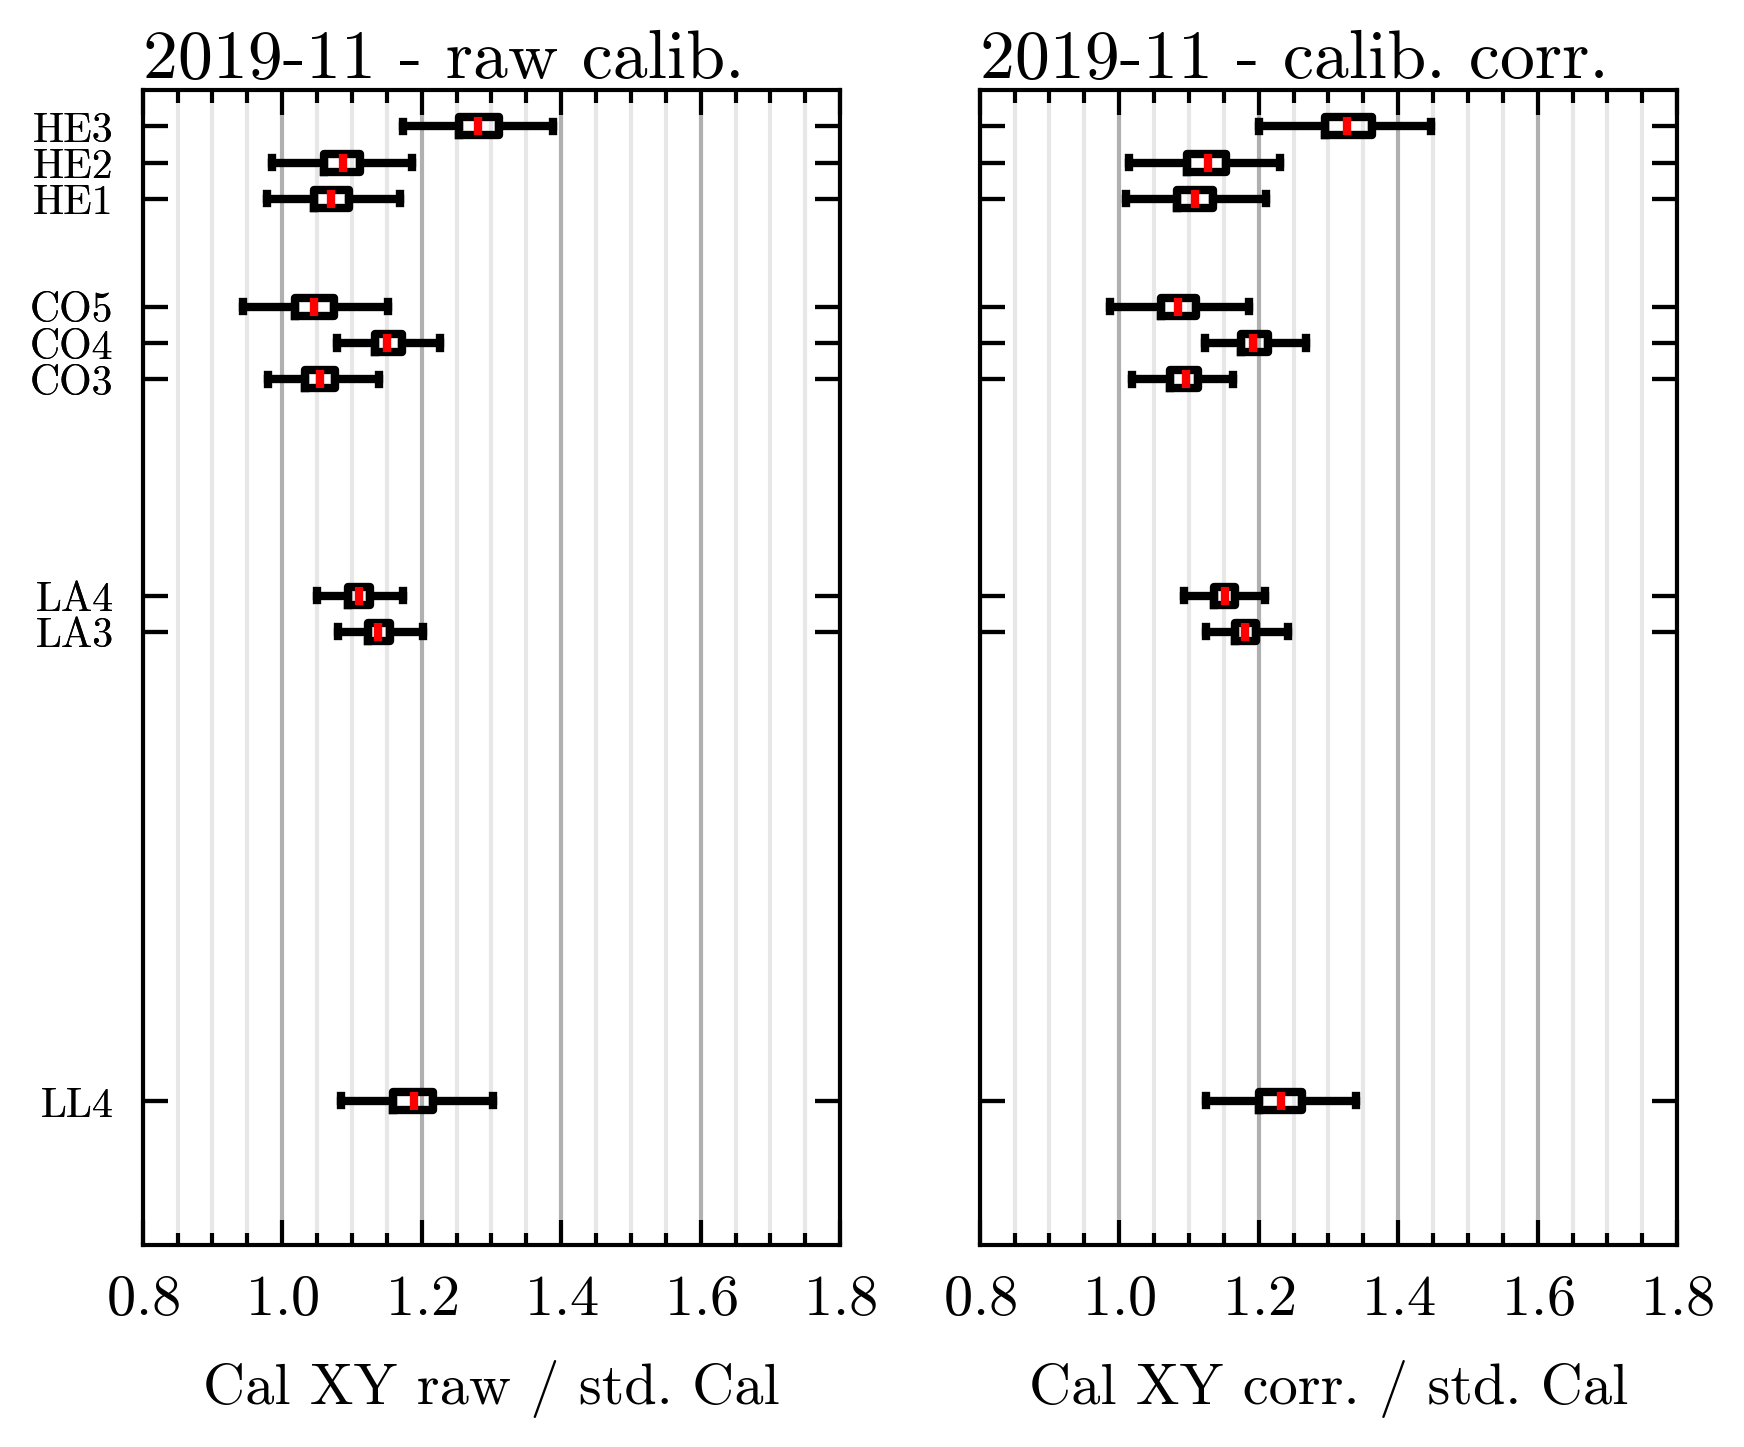

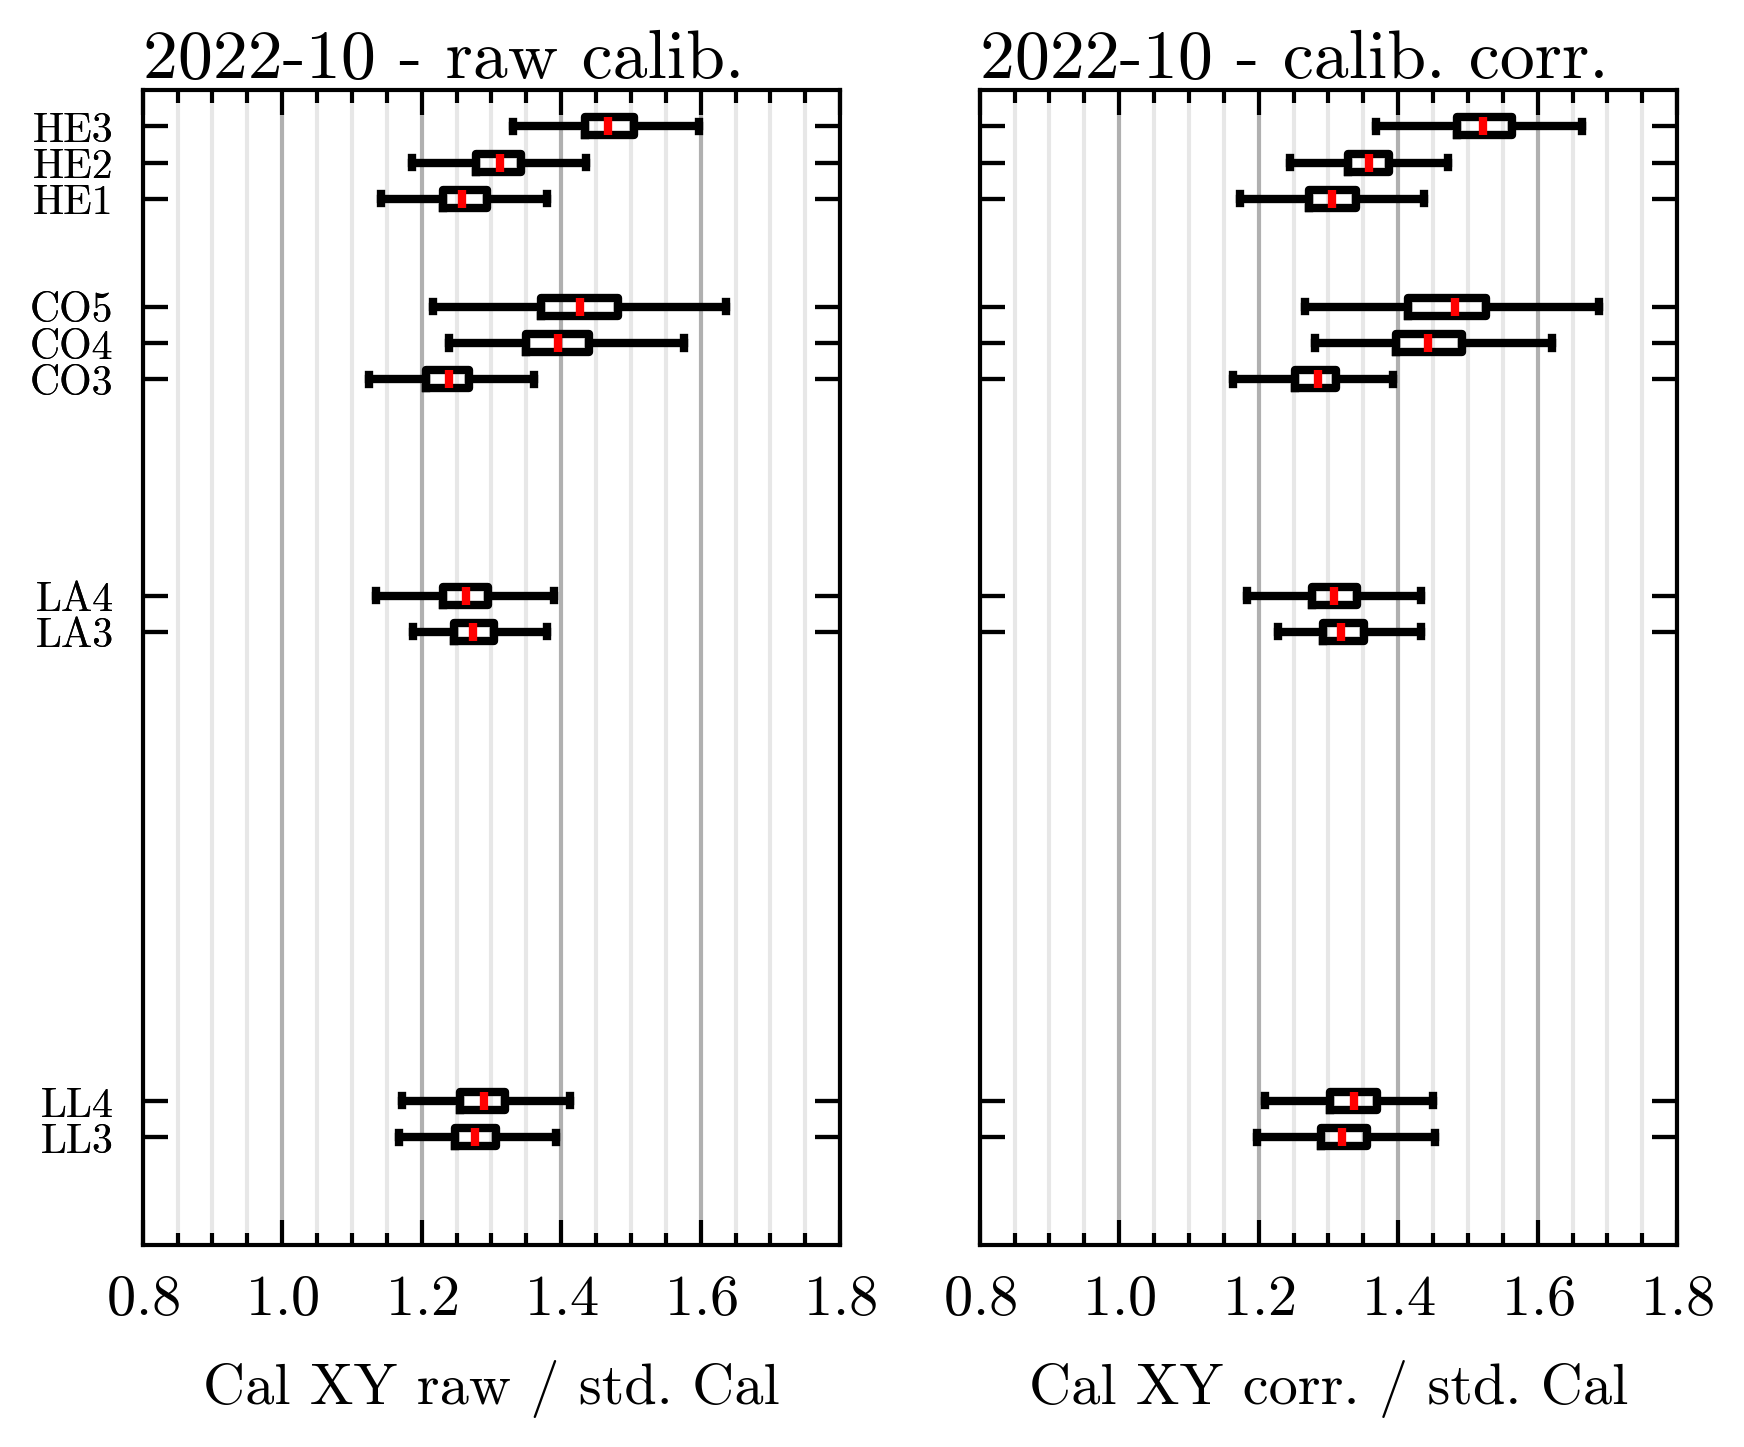

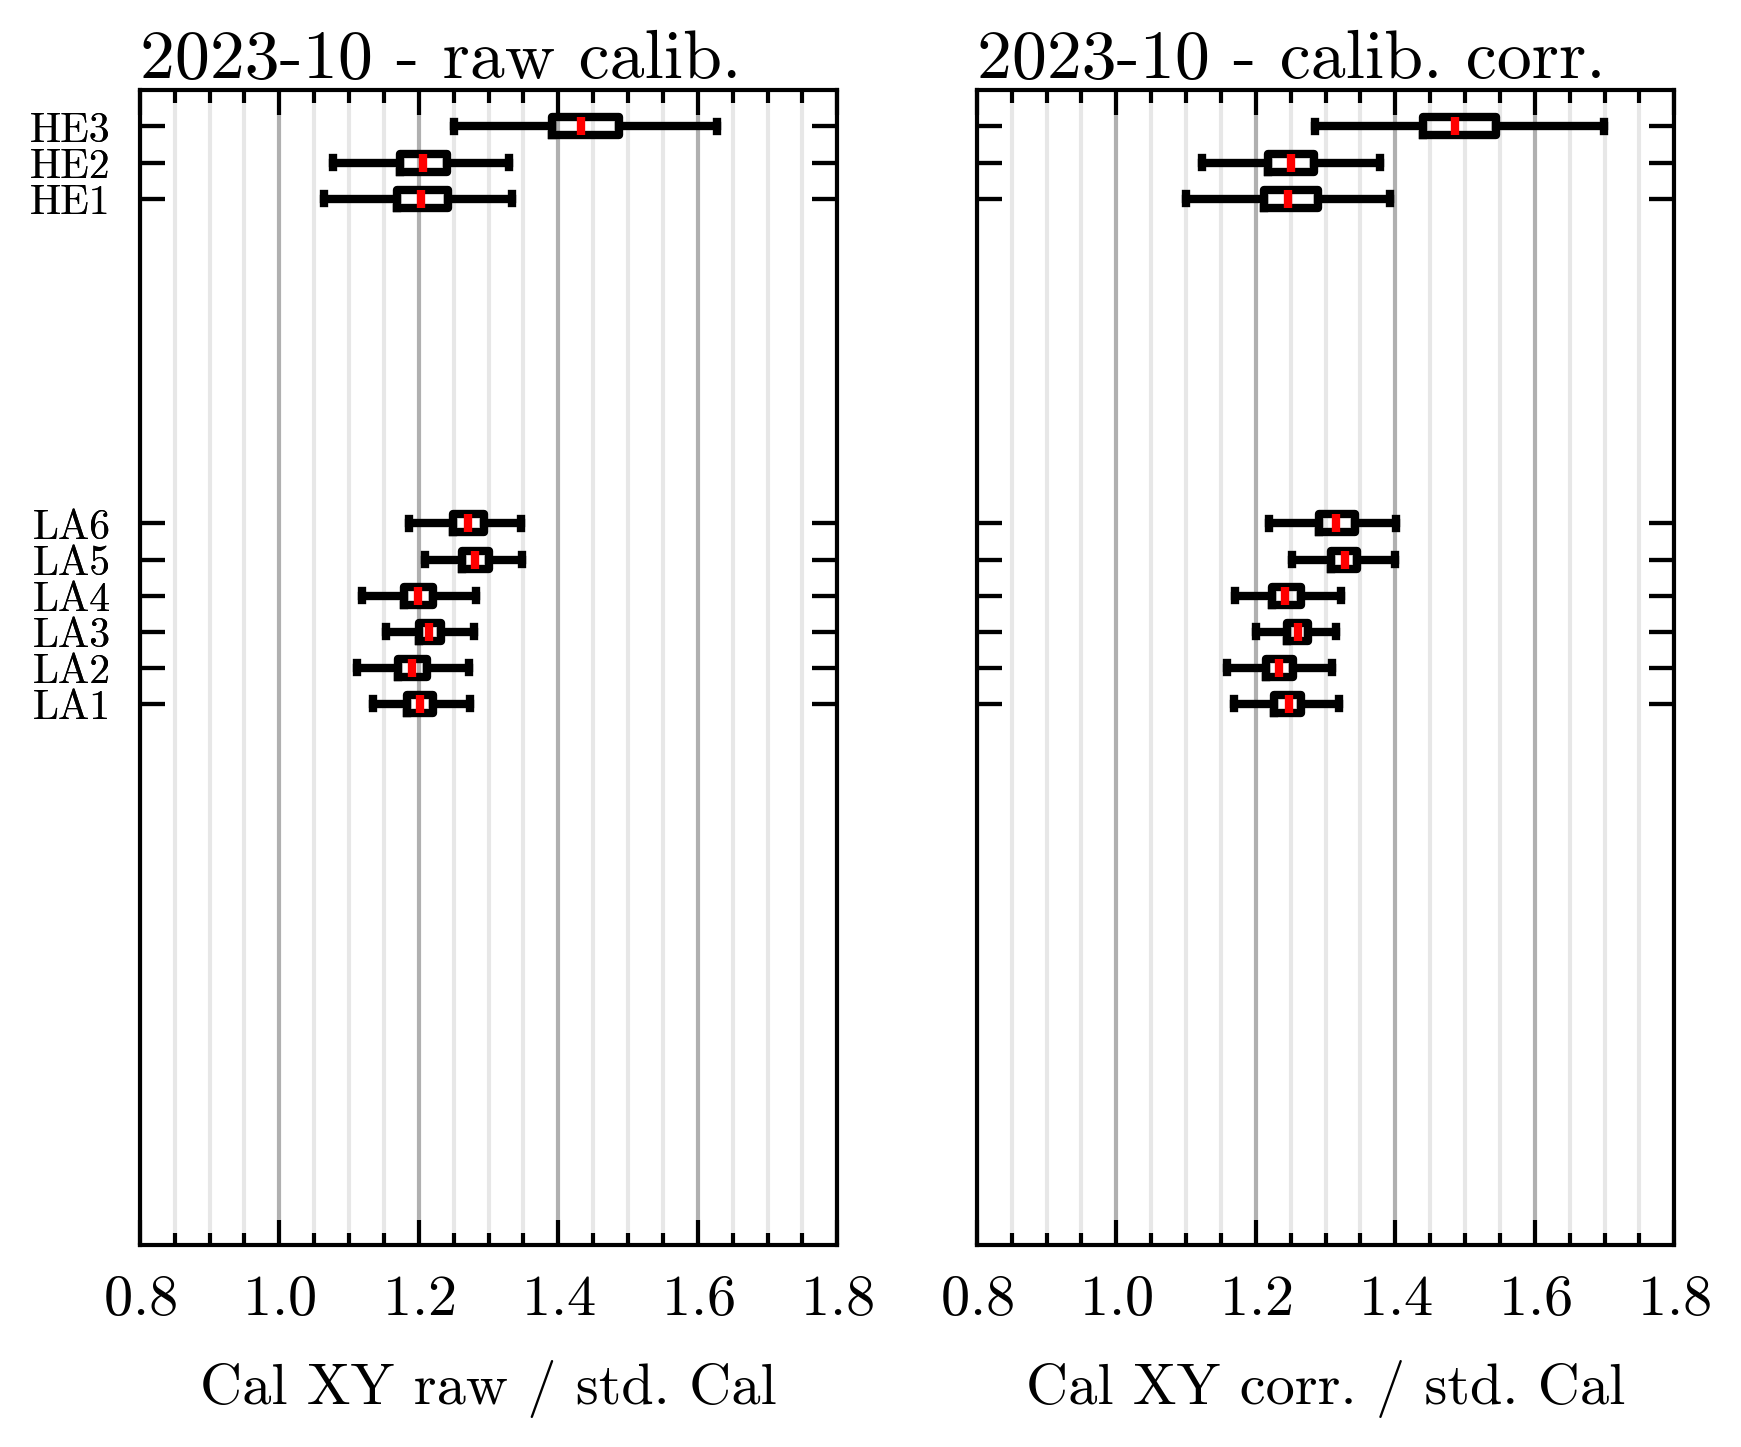

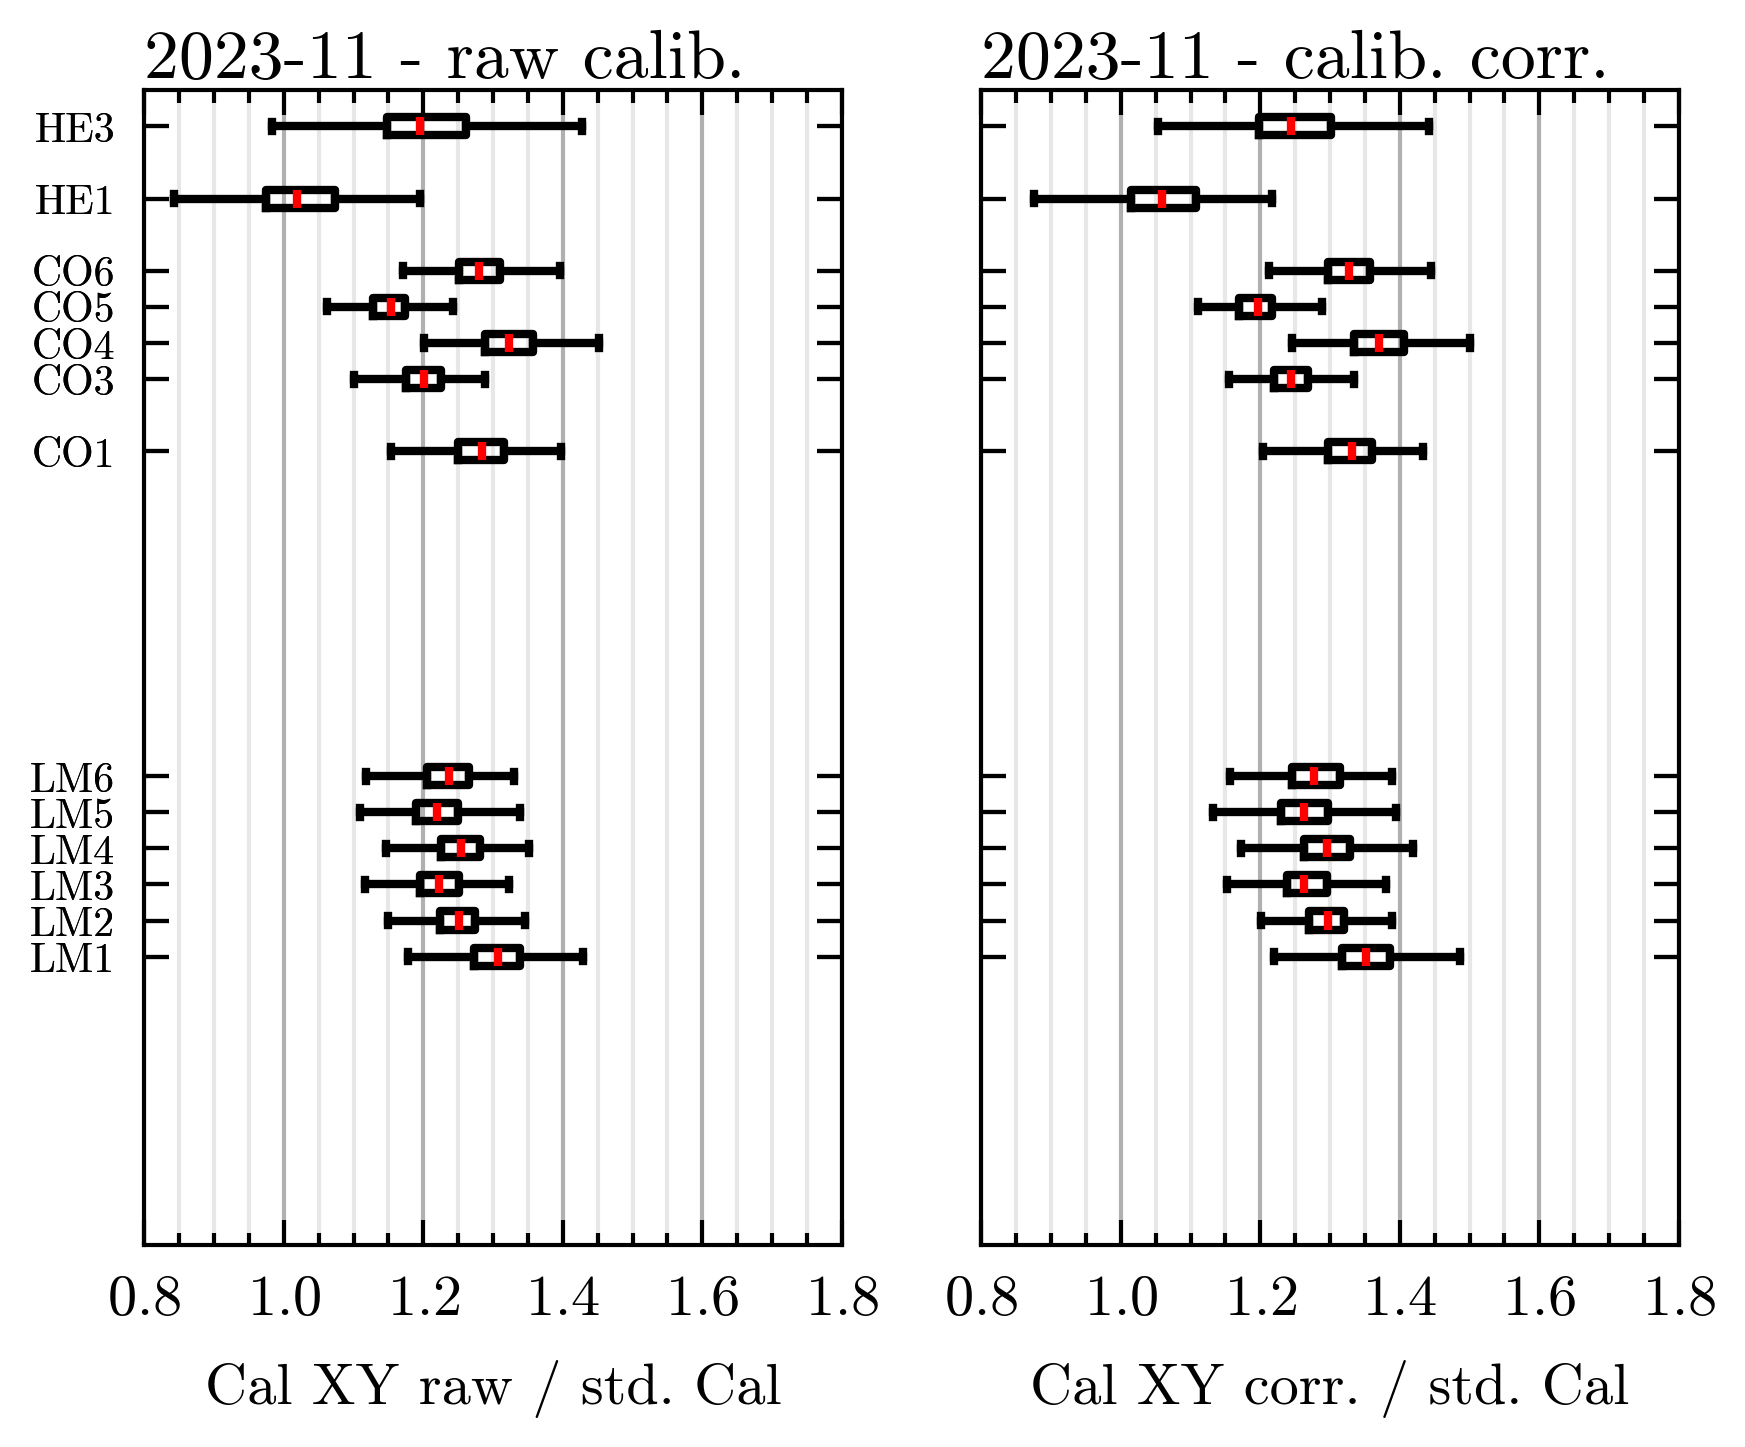

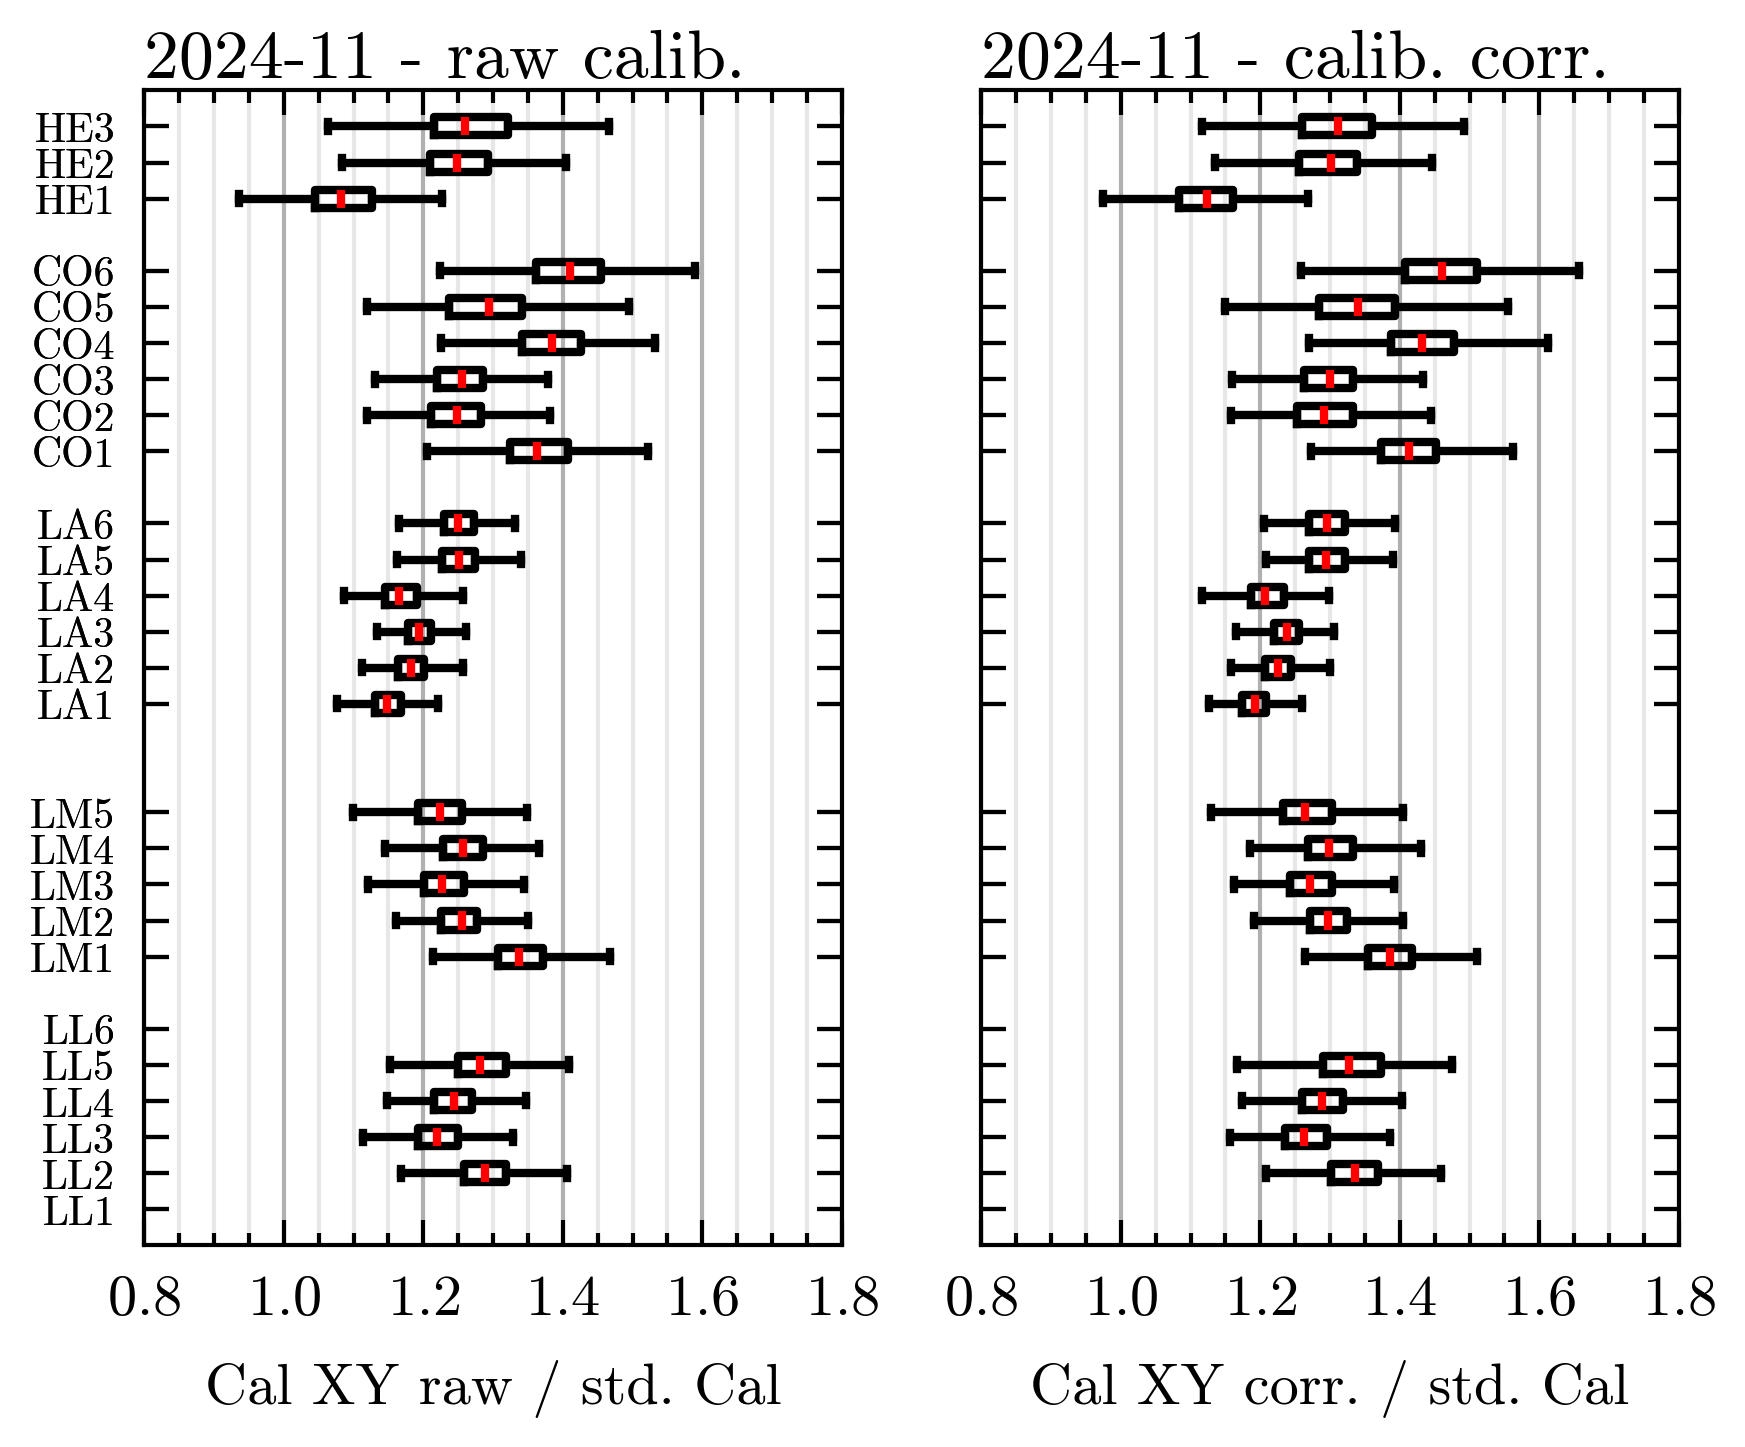

In [13]:
runlist_dir = '/home/filip/xy-calibration/config/calib_runlists/'
source_dir = '/home/filip/xy-calibration/results/'

reject = [''
          '15952x',     # co2 due to ??? (ASK!!!!!!!!!!)
          '15920x',     # co5 due to curtain in aperture
          '6075',       # he2 due to cold electronics
          ]

# fig, axes = plt.subplots(4, 1, sharex=True)

figs_and_axes = [plt.subplots(1, 2, sharey=True) for _ in range(5)]
figs, axes = [a[0] for a in figs_and_axes], [a[1] for a in figs_and_axes]

for (ax1, ax2), list, fig in zip(axes, ['2019-11', '2022-10', '2023-10', '2023-11', '2024-11'], figs):

    ax1.set_yticks([], minor = True)
    ax1.set_yticklabels([], fontsize=5)
    ax1.set_xticks(np.arange(0.8, 1.8, 0.05), minor=True)   # set minor ticks on x-axis
    ax2.set_xticks(np.arange(0.8, 1.8, 0.05), minor=True)   # set minor ticks on x-axis
    ax1.set_xticks(np.arange(0.8, 1.9, 0.2))
    ax2.set_xticks(np.arange(0.8, 1.9, 0.2))
    ax1.set_ylim(0, 32)

    ax1.text(0, 1, f"{list} - raw calib.", transform=ax1.transAxes,
            ha='left', va='bottom', fontsize='large', fontweight='bold')
    ax2.text(0, 1, f"{list} - calib. corr.", transform=ax2.transAxes,
            ha='left', va='bottom', fontsize='large', fontweight='bold')
    ax1.set_xlabel(r"Cal XY raw / std. Cal")
    ax2.set_xlabel(r"Cal XY corr. / std. Cal")
    ax1.set_xlim(0.8, 1.8)
    ax2.set_xlim(0.8, 1.8)
    ax1.grid(axis='x')
    ax2.grid(axis='x')
    ax1.grid(axis='x', which='minor', alpha=0.3)
    ax2.grid(axis='x', which='minor', alpha=0.3)

    with open(f'{runlist_dir}calib_runs_{list}.list', 'r') as f:
        header = f.readline().strip().split(';')

    df = pd.read_csv(f'{runlist_dir}/calib_runs_{list}.list',
                     comment='#', delimiter=';', names=header)
    
    pos, label, data, data_corr = [], [], [], []

    for i, run in df.iterrows():
        if run['#runid'].strip() in reject: continue
        if not run['forDB']: continue
        if not run['source'].strip() in ['"OLO"', "OLO"]: continue
        if not run['comment'].strip() != '': continue

        try:

            cal_xy, cal_std, cal_xy_corr = np.loadtxt(f'{source_dir}/outCorr_{run["#runid"]}.txt', usecols=[1, 3, 4], unpack=True)
            # if run['#runid'] in ['12806', '12809']:
            #     cal_std = np.loadtxt(f'{runlist_dir}/../../save_{run["#runid"].strip()}.txt', usecols=[3])

            if os.path.isfile(pixel_mask_file := f'{runlist_dir}/../pixel_masks/{run["telescope"].strip()}.txt'):
                pixel_mask = np.loadtxt(pixel_mask_file, usecols=[-1], dtype=bool)
            else:
                pixel_mask = np.ones(440, dtype=bool)

            cal_xy[~pixel_mask] = np.nan
            cal_xy_corr[~pixel_mask] = np.nan

            pos.append(format(run['telescope'].strip()))
            label.append(run['telescope'].strip().upper())
            data.append(cal_xy / cal_std)
            data_corr.append(cal_xy_corr / cal_std)

            # os.system(f'mkdir -p /home/filip/Desktop/pixel_constants/{list}/')
            # np.savetxt(f'/home/filip/Desktop/pixel_constants/{list}/{run["telescope"].strip()}', 
            #            np.column_stack([np.arange(1, 441, 1), data[-1], data_corr[-1]]), fmt='%s')

        except FileNotFoundError: 
            continue
        
    # pixel calibConst adcSum stdCalib calibConstCorr
    ax1.boxplot(data, positions=pos, vert=False, tick_labels=label, showfliers=False, widths=0.5)
    ax2.boxplot(data_corr, positions=pos, vert=False, tick_labels=label, showfliers=False, widths=0.5)

    plt.subplots_adjust(hspace=0)
    # raise StopIteration

    # np.savetxt(f'/home/filip/Desktop/{list}.txt', np.column_stack([label, np.nanmedian(data, axis=1), np.nanmedian(data_corr, axis=1)]), fmt='%s')
    # fig.savefig(f'/home/filip/Desktop/{list}.png')